In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import xarray as xr

import sys
sys.path.insert(0, "../src")
from swe import ShallowOne
from figures import figure_sizes, texp

In [2]:
# HACK(connor) to get x-coords
swe = ShallowOne(
    control=dict(nx=500, dt=0.01, theta=0.6, simulation="immersed_bump"),
    params=dict(nu=1e-6, bump_centre=10))


def plot_means_vars(output_files):
    """ Read in errors from output file. """
    
    n_models = len(output_files)
    fig, axs = plt.subplots(2, n_models,
                            constrained_layout=True,
                            dpi=600, figsize=(figure_sizes["fullwidth"], 3),
                            sharey="row", sharex=True)
    
    for col, file in enumerate(output_files):
        checkpoint = h5py.File(file, "r")
        nu = checkpoint["/"].attrs["nu"]
        nx_skip = checkpoint["/"].attrs["nx_skip"]
        # c = checkpoint["/"].attrs["c"]
        # nt_skip = checkpoint["/"].attrs["nt_skip"]
        # k = checkpoint["/"].attrs["k"]
        # linear = checkpoint["/"].attrs["linear"]

        # just verify we are doing the correct thing
        idx_plot = 18_000
        assert checkpoint["/"].attrs["rho_h"] == 1.
        t_plot = checkpoint["/t"][idx_plot]
        t_obs = checkpoint["/t_obs"][180]
        
        # get data
        dat = xr.open_dataset("../data/h_bump.nc")
        t_obs = dat.coords["t"].values[idx_plot + 1]
        x_obs = dat.coords["x"].values[::nx_skip]
        y_obs = dat["h"].values[idx_plot + 1, ::nx_skip]  # dont include IC
        np.testing.assert_allclose(t_plot, t_obs)

        # running across it all
        u_mean = checkpoint["/u_mean"][idx_plot, :]
        u_var = checkpoint["/u_var"][idx_plot, :]
        h_mean = checkpoint["/h_mean"][idx_plot, :]
        h_var = checkpoint["/h_var"][idx_plot, :]
        rmse_rel = np.mean(checkpoint["/rmse_rel"][:])  # average RMSE for comparison?
        checkpoint.close()
    
        x_grid = swe.x_coords
        axs[0, col].plot(x_grid, u_mean)
        axs[0, col].fill_between(x_grid[:, 0], 
                            u_mean - 1.96 * np.sqrt(u_var), u_mean + 1.96 * np.sqrt(u_var),
                            alpha=0.2)
        if nu == 0.:
            axs[0, col].set_title(fr"Linear" + "\n" + f"(RRMSE: {rmse_rel:.3f})")
        else:
            num = texp(f"{nu:.1e}", dollar_surround=False)
            axs[0, col].set_title(fr"$\nu = {num}$" + "\n" + f"(RRMSE: {rmse_rel:.3f})")
    
        axs[1, col].plot(x_obs, y_obs, ".", color="black", markersize=1.5)
        axs[1, col].plot(x_grid, h_mean)
        axs[1, col].fill_between(x_grid[:, 0], 
                                 h_mean - 1.96 * np.sqrt(h_var), h_mean + 1.96 * np.sqrt(h_var),
                                 alpha=0.2)
        axs[1, col].set_xlabel(r"$x$")
        
    axs[0, 0].set_ylabel(r"$u$")
    axs[1, 0].set_ylabel(r"$\eta$")
    plt.savefig("../figures/intro-example-means-vars.pdf")

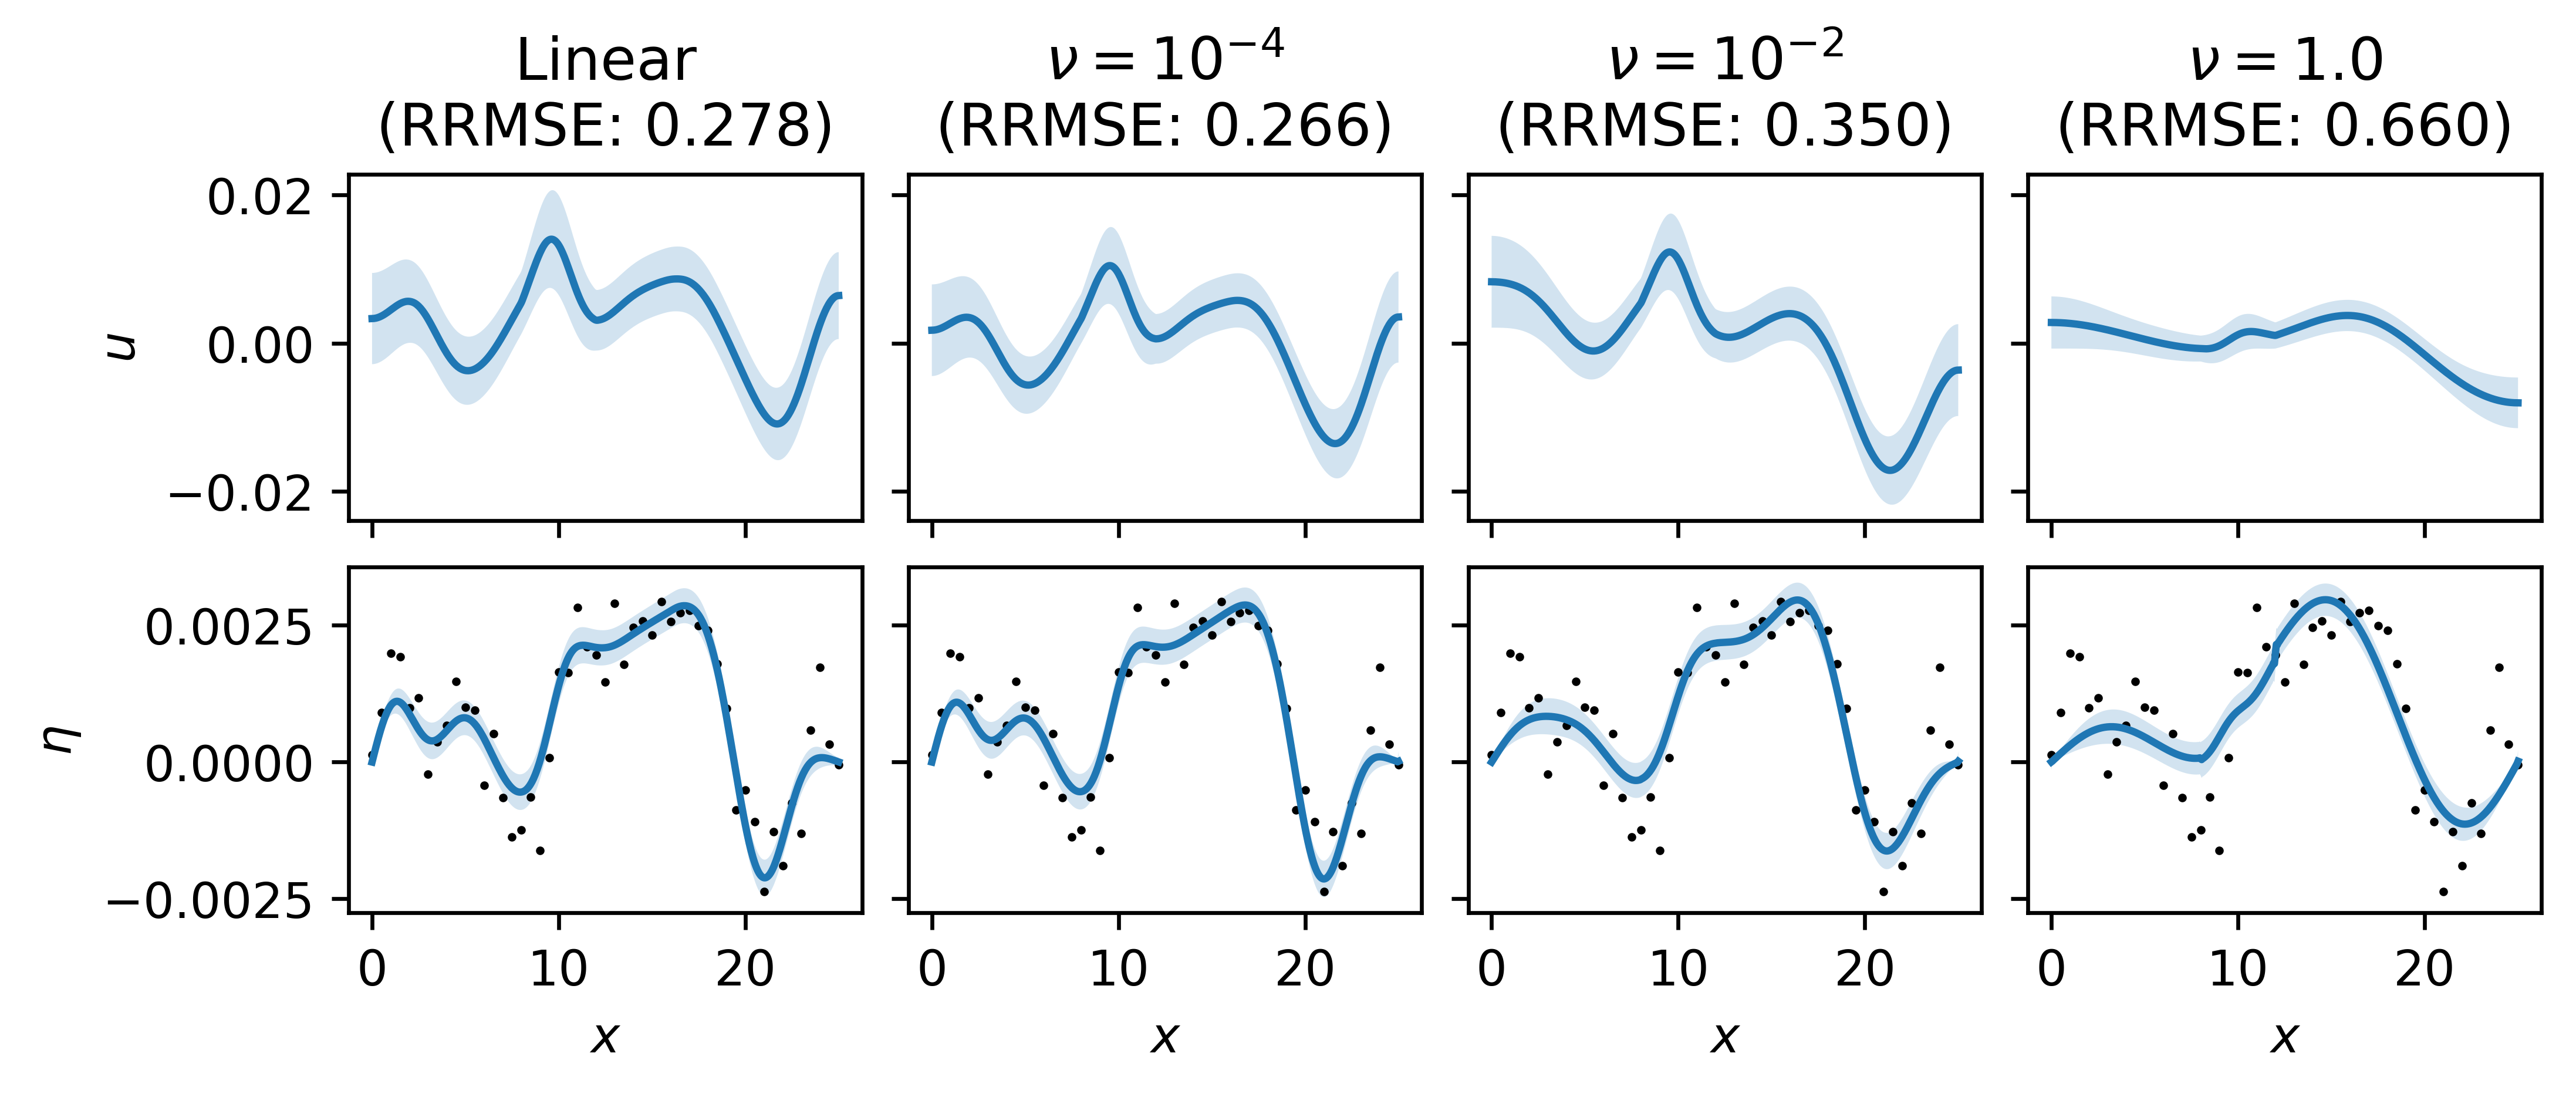

In [3]:
files = ["../outputs/linear-posterior-c-10.0-nt_skip-100-nu-0.00e+00-k-32.h5",
         "../outputs/nonlinear-posterior-c-10.0-nt_skip-100-nu-1.00e-04-k-32.h5",
         "../outputs/nonlinear-posterior-c-10.0-nt_skip-100-nu-1.00e-02-k-32.h5",
         "../outputs/nonlinear-posterior-c-10.0-nt_skip-100-nu-1.00e+00-k-32.h5"]
plot_means_vars(files)

In [4]:
def get_errors(output_file):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    c = checkpoint["/"].attrs["c"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 1.
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    # common coordinates across all
    coords=dict(t=t_obs,
                nu=np.array([nu]))
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis],
                           coords=coords,
                           name="rmse")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis],
                               coords=coords,
                               name="rmse_rel")
    return xr.merge([rmse_ds, rmse_rel_ds])


errors_ds = []
for file in files:
    e = get_errors(file)
    errors_ds.append(e)

errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear

<xarray.Dataset>
Dimensions:   (t: 200, nu: 4)
Coordinates:
  * t         (t) float64 0.01 1.01 2.01 3.01 4.01 ... 196.0 197.0 198.0 199.0
  * nu        (nu) float64 0.0 0.0001 0.01 1.0
Data variables:
    rmse      (t, nu) float64 6.788e-05 6.788e-05 ... 7.635e-05 0.0001087
    rmse_rel  (t, nu) float64 0.1231 0.1231 0.1231 ... 0.3937 0.4428 0.6301

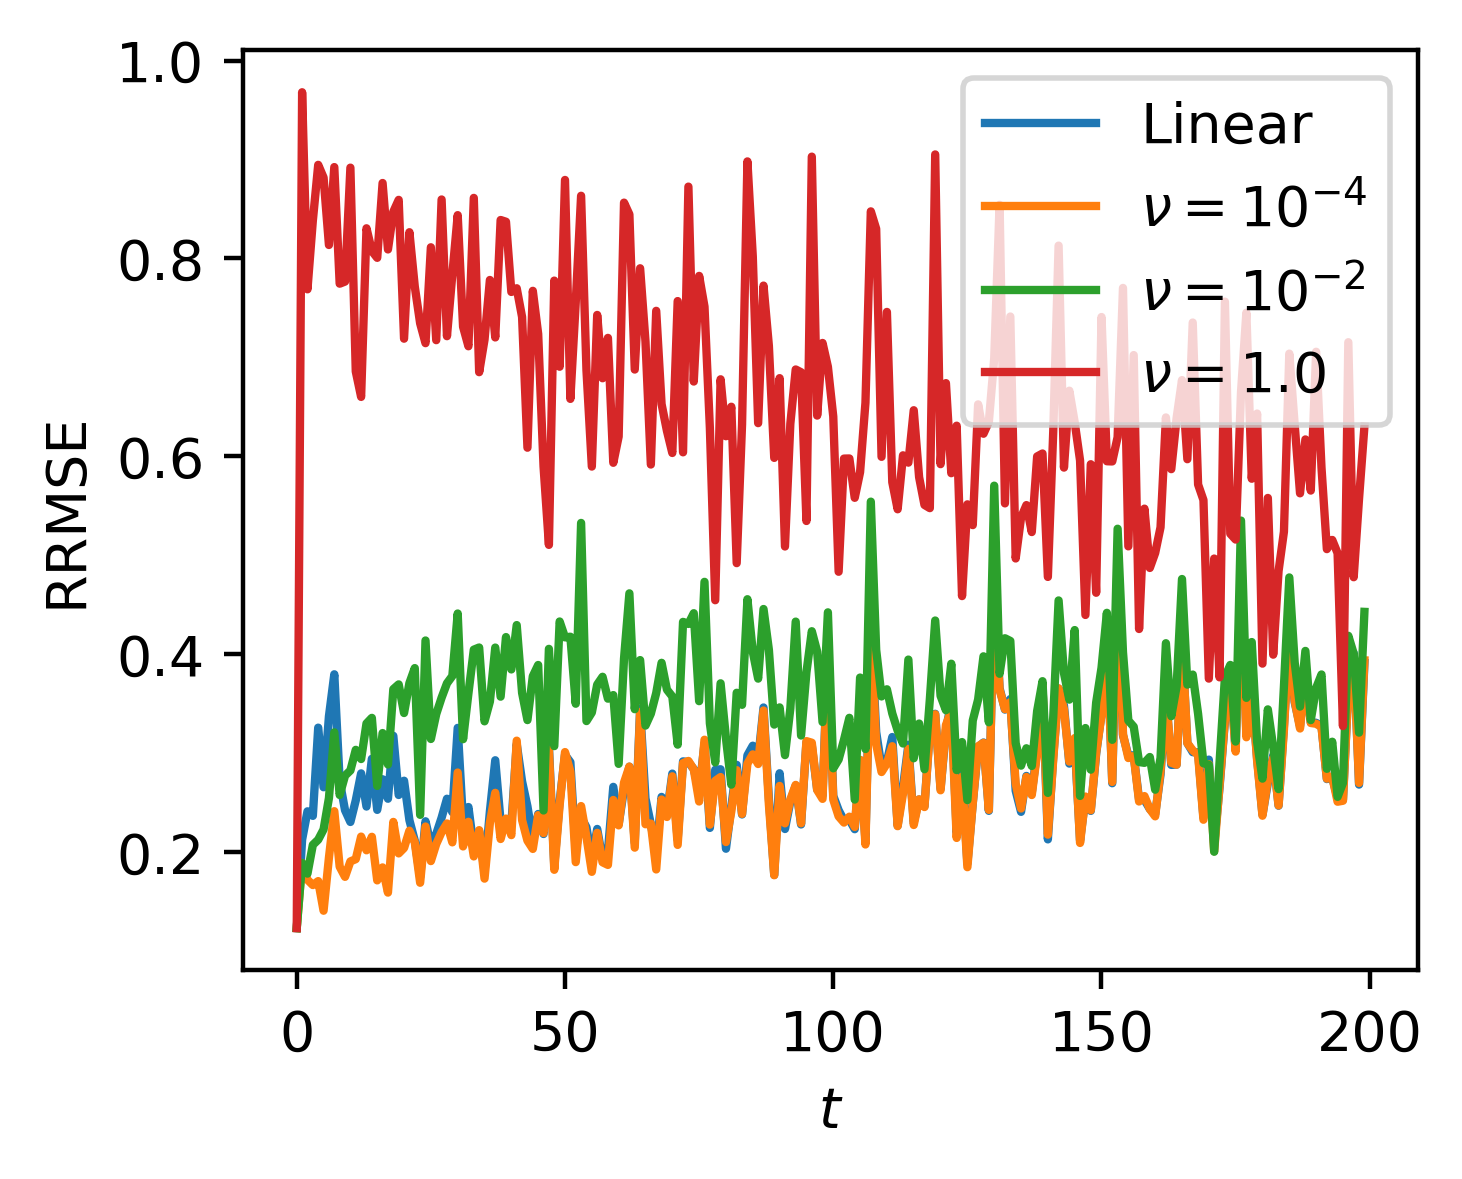

In [5]:
fig, ax = plt.subplots(1, 1, 
                       constrained_layout=True, 
                       figsize=(1. * figure_sizes["halfwidth"], 
                                0.8 * figure_sizes["halfwidth"]),
                       dpi=400)
errors_nonlinear.rmse_rel.plot(hue="nu", ax=ax)
nus =  errors_nonlinear.coords["nu"].to_numpy()

labels = [
    fr"$\nu = {texp(f'{nu:.1e}', False)}$" if nu > 0 else "Linear" for nu in nus
]
ax.legend(labels=labels)
ax.set_ylabel("RRMSE")
ax.set_xlabel(r"$t$")
plt.savefig("../figures/intro-example-rrmse.pdf")